To make AI writer
=
> ## 목차
> ---
> ### 1. 실행 방법   
> ### 2. 목표 및 의의   
> ### 3. 이론 [go](#3-이론)
>   > 1 RNN과 LSTM
>   > 2 
> ### 4. 코드 분석 [go](#4-코드-분석)
>   > [1 데이터 준비 및 정제](#1-데이터-준비-및-정제)    
>   > [2 모델 설계](#2-모델-설계)   
>   > [3 학습!](#3-학습)   
>   > [4 모델 평가](#4-모델-평가)   
> ### 5. 아쉬운 점 [go](#5-아쉬운-점)

---
# 1. 실행 방법
  1. 왠만한 그래픽카드로도 학습시간이 한,두시간 걸리는 것 같으니, 해보길 크게 권하지 않습니다. 그래도 꼭 하고싶으면 해보세요!
  2. aiffel repository를 다운받습니다. ``` git clone https://github.com/SunCreation/aiffel.git```
  3. writer.py를 실행해줍니다. ```python3 {aiffel까지 경로}/aiffel/Working/AI/writer/writer.py``` {aiffel까지 경로} 추가 입력, 학습이 시작됩니다.(라이브러리 tensorflow, matplotlib, sklearn 가 필요합니다.)
  4. 학습결과는 아래내용 그 이상이 없으므로, 굳이 해보실 필요 없습니다.
  
---
# 2. 목표 및 의의
  - 그럴 듯한 글을 쓰는 인공지능을 만든다.
  - 원하는 바를 해본다: 인공지능이 만들어주는 글의 길이 조절, 학습데이터 정제.
  - LSTM에 대하여 이해해본다.
  - mini_batch를 활용하는 방법을 익힌다.
  - 적절한 hidden_size, embedding_size를 정할 방법을 생각해본다.
  - validation loss 값이 의미하는 바를 안다.

---
# 3. 이론
[목차](#to-make-ai-writer)
## 1) RNN과 LSTM
---
#### RNN(Recurrent Neural Networks)은 인공 신경망 학습모델의 일종으로, hidden_node가 방향을 가지고 연결돼 순환구조를 이루는(directed cycle) 형태를 가지고 있습니다. 이 역시 실제 뇌의 신경에서 본따온 학습형태라고 합니다.

![이미지](https://i.imgur.com/Q8zv6TQ.png)

#### 위의 그림에서도 알 수 있듯 시퀀스 길이에 관계없이 인풋과 아웃풋을 받아들일 수 있는 네트워크 구조이기 때문에 필요에 따라 다양하고 유연하게 구조를 만들 수 있다는 점이 RNN의 가장 큰 장점입니다.
#### 하지만 vanishing gradient problem라고 하는 문제가 존재합니다. 바로 학습데이터와 연관된 타겟데이터가 멀리있을 때, 학습률이 떨어지는 현상인데, RNN을 사용할 경우에는 이런 일이 많기때문에, 이는 큰 문제중에 하나라고 할 수 있습니다.

#### 이어서 LSTM은 다음과 같은데, 바로 vanishing gradient problem을 해결 할 방법이라고 할 수 있겠습니다. 세부 적인 내용은 차차 알아가 보겠습니다!
![이미지](https://i.imgur.com/jKodJ1u.png)

---
# 4. 코드 분석
[목차](#to-make-ai-writer)
## 1) 데이터 준비 및 정제
---
#### 이번에는 노래 가사를 쓰는 인공지능을 만들도록 해볼게요. tf.keras.layers.LSTM모델을 사용할겁니다!
 


In [1]:
import glob
import os
import re
from sklearn.utils import validation 
import tensorflow as tf
import numpy as np
from tensorflow.python.ops.nn_ops import dropout

txt_files ='data/lyrics/*'
txt_file_path ='data/lyrics' 
txt_list = glob.glob(txt_files)
txt_name_list = os.listdir(txt_file_path)
raw_corpus = []



In [2]:
# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r",encoding='utf-8') as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)
            
print("노래제목 예시 5개:\n", txt_name_list[:5], "\n노래 개수:", len(txt_list))
print("데이터 크기:", len(raw_corpus))
print("Examples:\n", np.array(raw_corpus[:15]))





노래제목 예시 5개:
 ['michael-jackson.txt', 'paul-simon.txt', 'amy-winehouse.txt', 'bob-dylan.txt', 'bruce-springsteen.txt'] 
노래 개수: 49
데이터 크기: 187088
Examples:
 ['' '' '[Spoken Intro:]' 'You ever want something '
 "that you know you shouldn't have "
 "The more you know you shouldn't have it, " 'The more you want it '
 'And then one day you get it, ' "It's so good too "
 "But it's just like my girl " "When she's around me "
 'I just feel so good, so good '
 'But right now I just feel cold, so cold ' 'Right down to my bones '
 "'Cause ooh... "]


## - 데이터 정제하기
#### 이제 문장을 기계가 학습할 수 있는 숫자로 바꿔줄 것입니다. 그냥 encoding을 하면 되는게 아닌가 생각할 수 있지만, 저희는 문장들을 그저 기계어로 바꾸고 싶은 것이 아니라, 글자 하나하나가 대응되는 숫자가 있기를 원합니다. 따라서 단어들을 대응되는 숫자를 지정하는 Tokenize를 해봅시다!

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    
    return sentence

corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15 : continue
    corpus.append(preprocessed_sentence)



### 먼저 단어들을 잘 정리해봅시다. me 와 me, 등이 하나하나 전부 다르면 곤란하므로 다음과 위와같이 특수문자를 단어들과 분리합니다. 또 학습에 필요한 도구로서 문장의 앞뒤에 \<start>, \<end>를 넣어줍니다. 위 함수를 이용해서 문장을 모두 정제하겠습니다.

In [4]:
def tokenize(corpus):
    # 13000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 13000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=13000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다.
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다.
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다.
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer


tensor, tokenizer = tokenize(corpus)
print(tensor[:3, :10])
tensor.shape
#%%
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break


src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0][:10])
print(tgt_input[0][:10])

from sklearn.model_selection import train_test_split as ttst
enc_train, enc_val, dec_train, dec_val = ttst(src_input,
                            tgt_input,
                            test_size=0.2,
                            random_state=21)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

#%%


[[   2 2711 2353 ...    0    0    0]
 [   2    7  161 ...    0    0    0]
 [   2   15    7 ...    0    0    0]
 ...
 [   2   32  133 ...    0    0    0]
 [   2    4   61 ...    0    0    0]
 [   2  169    3 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f439ea10690>
[[   2 2711 2353    3    0    0    0    0    0    0]
 [   2    7  161   64  197    3    0    0    0    0]
 [   2   15    7   34    7 1629   16   74    3    0]]
1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to
[   2 2711 2353    3    0    0    0    0    0    0]
[2711 2353    3    0    0    0    0    0    0    0]
Source Train: (124810, 14)
Target Train: (124810, 14)


#### 이제 잘 학습되고 있는지, 확인할 목적으로 validation set을 나눠주겠습니다.(sklearn사용)

#### 원하는 모습으로 잘 나온 것 같아요!
#### 다음을 ft.data.Dataset 을 사용하여, 데이터를 학습하기 좋게 조정해볼게요.
dataset메소드에 관한 정보들   
[here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)   
tf.data.Dataset에는 알아주면 편리한 기능이 아주 많다고 해요.   
저는 tf.data.Dataset을 사용하여 입력데이터를 하나로 묶고, mini-batch로 나누어주었습니다.

In [5]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE
val_BUFFER_SIZE = len(enc_val)
 # tokenizer가 구축한 단어사전 내 13000개와, 여기 포함되지 않은 0:<pad>를 포함하여 13001개
VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset
val_dataset = val_dataset.shuffle(val_BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset
#%%



<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

[목차](#to-make-ai-writer)
## 2) 모델 설계
---
#### 이제 준비가 많이 되었군요. 학습을 할 모델을 만들어보겠습니다!
#### 오늘 인공지능이 해줬으면 좋겠는 일은 언어에 대한 학습입니다. 우리의 모델은 특정 단어를 특정 숫자로 인지할 수 밖에 없습니다. 이를 위해 단어들을 숫자와 해주는 작업을 이미 마쳤습니다. 이제 모델은 그 숫자에 특정 수치들을 매겨, 기억할 것입니다. 

In [6]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 1400
hidden_size = 2048
mywriter = TextGenerator(VOCAB_SIZE, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
print(mywriter(src_sample))
# #%%
# print(mywriter)
# test 14
mywriter.summary()
#%%


tf.Tensor(
[[[ 2.27168814e-04  2.24591829e-04  2.59923196e-04 ... -2.62834335e-04
    5.55005936e-05  2.94099329e-04]
  [ 1.67691323e-05  4.36665519e-04 -9.40987156e-05 ... -1.20378761e-04
    2.13345105e-04  1.02851016e-03]
  [-5.39508124e-04 -2.76321953e-05 -3.10240226e-04 ...  4.89324273e-04
    2.73176178e-04  1.10375811e-03]
  ...
  [-2.59967474e-03 -1.13959331e-03 -2.47546658e-03 ...  4.09871852e-03
    5.57829626e-04  1.54354231e-04]
  [-1.81715901e-03 -1.15971512e-03 -2.46666581e-03 ...  3.41451401e-03
    1.06869510e-03 -7.39549403e-04]
  [-1.01525581e-03 -1.31073152e-03 -2.49895523e-03 ...  2.53617228e-03
    1.73966668e-03 -1.59957365e-03]]

 [[ 2.27168814e-04  2.24591829e-04  2.59923196e-04 ... -2.62834335e-04
    5.55005936e-05  2.94099329e-04]
  [ 2.21413371e-04  3.57676210e-04  9.02355023e-05 ... -4.31843160e-04
    1.97494992e-05  5.68016025e-04]
  [ 3.17645347e-04  3.48460802e-04 -2.67675263e-04 ...  4.96235443e-04
   -2.43743663e-04  5.88113558e-04]
  ...
  [-1.236539

[목차](#to-make-ai-writer)
## 3) 학습!
---
#### 이제 학습을 하며 확인할 값들을 정의해주고, 학습을 시작하겠습니다!

In [7]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

mywriter.compile(loss=loss, optimizer=optimizer)
lyricist = mywriter.fit(dataset, 
                    validation_data=val_dataset,
                    epochs=8)


Epoch 1/8
487/487 [==============================] - 562s 1s/step - loss: 3.6775 - val_loss: 2.8327
Epoch 2/8
487/487 [==============================] - 560s 1s/step - loss: 2.7021 - val_loss: 2.5728
Epoch 3/8
487/487 [==============================] - 559s 1s/step - loss: 2.3301 - val_loss: 2.3941
Epoch 4/8
487/487 [==============================] - 558s 1s/step - loss: 1.9753 - val_loss: 2.2670
Epoch 5/8
487/487 [==============================] - 569s 1s/step - loss: 1.6534 - val_loss: 2.1845
Epoch 6/8
487/487 [==============================] - 559s 1s/step - loss: 1.3878 - val_loss: 2.1396
Epoch 7/8
487/487 [==============================] - 564s 1s/step - loss: 1.1943 - val_loss: 2.1333
Epoch 8/8
487/487 [==============================] - 558s 1s/step - loss: 1.0678 - val_loss: 2.1498


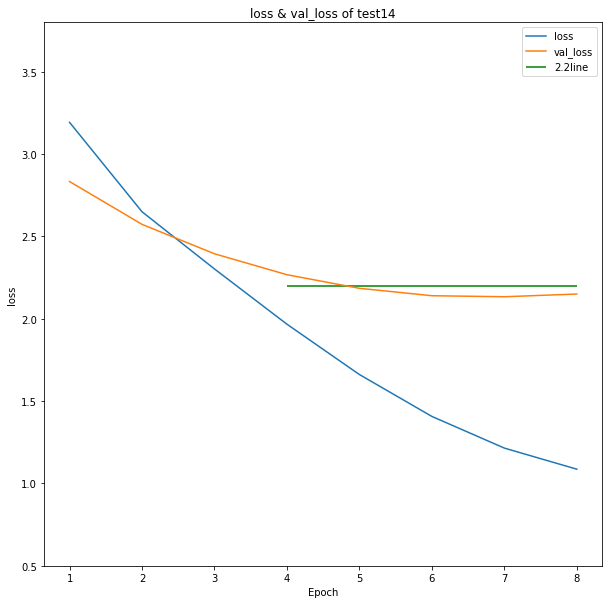

In [22]:
import matplotlib.pyplot as plt
plt.figure(1,(10,10))
plt.plot(range(1,9),lyricist.history['loss'])
plt.plot(range(1,9),lyricist.history['val_loss'])
plt.hlines(2.2, 4, 8, colors='g')
plt.ylim(0.5,3.8)
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('loss & val_loss of test14')
plt.legend(["loss","val_loss","2.2line"],loc='upper right')
plt.show()

#### AIFFEL 요구사항에서는 val_loss를 2.2아래로 맞춰보라고 했는데, 이정도면 그래도 조금 낮게 나온 것 같아요:)

#### 지금까지 나온 코드에서 batch_size, embadding_size, hidden_size를 조절해가며, 어떤 값에따라 val_loss가 달라지는지(새로운 노래가사에서 뒤에 내용을 비슷하게 맞추는지)를 확인해볼게요.

#### 여러가지 실험을 해본 결과는 다음과 같아요.

|구분|batch_size|embadding_size|hidden_size|epochs|loss / val_loss|비고|
|---|---:|---:|---:|---:|---|---|
|test1|256|256|1024|10|2.2335/ 2.5371|AIFFEL제시값, 학습시간: 53분|
|test2|512|256|1024|10|2.4980/ 2.6593|학습시간: 42분|
|test3|512|256|2048|10|2.2654/ 2.5407|학습시간: 105분|
|test4|512|512|2048|10|1.8706/ 2.3590|학습시간: 135분|
|test5|256|512|2048|10|1.0427/ 2.2050|특징: val_loss가 2.1862까지 떨어져서 다시 상승, 학습시간: 137분|
|test6|256|512|2048|10|1.2702/ 2.2055|지현님의 아이디어로 drop-off추가, 학습시간: 103분|
|test7|512|512|2048|10|1.6553/ 2.2763|지현님의 아이디어로 drop-off추가, dropout=0.05|
|test8|256|800|2048|10|0.9866/ 2.1858|특징: 초반에 val_loss가 6번째에 이미 2.1731에 도달 이후 조금 내려갔다가 다시 상승, 학습시간: 109분|
|test9|256|512|1024|10|2.1131/ 2.4764|학습시간: 65분|
|test10|256|1024|2048|10|0.9712/ 2.1796|학습시간: 111분|
|test11|256|1024|2048|8|1.1064/ 2.1310|학습시간: 70분(구글코랩)|
|test12|256|1400|2048|8|1.0631/ 2.1280|학습시간: 70분(구글코랩)|


#### 미친듯이 맨땅에 해딩을 하다보니, 변수에 따른 추세가 조금 눈에 들어오는 것 같아요. 일단 대략적인 추세는 batch_size에는 학습에 영향이 크게 없고, embadding_size,	hidden_size과 val_loss가 음의 상관관계를 보이네요. 
> #### test5 의 loss graph
![그래프](model_data/test5.png)
#### 또 test 5 이후로는 epochs가 7까지는 잘 내려가다가 다시 올라가는 듯한 모습이 확인되요. 그 이상의 학습은 과적합을 유도할 뿐이라는 생각이 듭니다.

#### 과적합을 방지하기 위한 dropout은 크게 의미있는 결과로 느껴지지 않았습니다. 하지만 작사 결과는 달라질 수 있다는 생각도 들어요.

#### 결과를 종합하여, 가장 이상적이라고 생각하는 embadding_size = 1024,	hidden_size = 2048 모델로, epochs = 8로 학습한 결과입니다!
> #### test12 의 loss graph
![그래프](model_data/test12.png)
#### 목표 점수?에 도달했으니, 한번 실제로 평가를 해보겠습니다.




[목차](#to-make-ai-writer)
## 4) 모델 평가
---

#### 글을 쓰는 모델은 사람이 평가할 수 밖에 없어요. 생각하기로는 분명 loss값을 더 줄일 수도 있을 것이지만, AIFFEL에서 2.2만 요구한 이유가 무엇일까요? 일단 줄이기 어렵기 때문일 수도 있죠. 하지만 그 이상 줄이려고 노력하는 것이 의미가 없기 때문이 아닐까 하는 생각이 들었습니다. 그 이유는 다음과 같아요. 
#### 먼저 모델을 평가하기 위해서는 글을 만들게 시켜서 내가(사람이) 평가하는게 가장 의미있다고 생각합니다. 정답이 없기 때문이죠.
#### 모델을 이용해서 글을 만드는 함수를 만들어보겠습니다!

In [18]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [20]:
generate_text(mywriter, tokenizer, init_sentence="<start> hi")




'<start> hi ! my name is huh ? <end> '

In [21]:
test_word = ['man', 'i love', 'is it','it' ,'it was', 'how', 'how nice', 'how to kill', 'safety', 'beautiful','lielfsdf']
result_dict = {}
for word in test_word:
    result = generate_text(mywriter, tokenizer, init_sentence= ' '.join(["<start>", word]))
    print("- ",word,': ', ' '*(12-len(word)), result, sep= "")

- man:          <start> man i m the mocho like randy <end> 
- i love:       <start> i love you for your pink cadillac <end> 
- is it:        <start> is it worth it , let me work it <end> 
- it:           <start> it s all right we got you <end> 
- it was:       <start> it was a perfect illusion perfect illusion <end> 
- how:          <start> how do you <end> 
- how nice:     <start> how nice is the little stone <end> 
- how to kill:  <start> how to kill you for e so blue <end> 
- safety:       <start> safety for your love <end> 
- beautiful:    <start> beautiful people don t stress stress stress <end> 
- lielfsdf:     <start> <unk> <unk> <unk> <unk> <end> 


#### 위와같이 시작단어 여러개를 받아서 해당하는 문장을 받아보겠습니다. 


```

test4 작품 loss = 1.8706 / val_loss = 2.3590
- man:          <start> man i m a survivor <end> 
- i love:       <start> i love you so much <end> 
- it:           <start> it s a new day , it s a new day <end> 
- it was:       <start> it was a perfect illusion <end> 
- how:          <start> how many times i gotta tell that ass to come over ? <end>
- how nice:     <start> how nice to be <end> 
- how to kill:  <start> how to kill you <end>    
- safety:       <start> safety out of my head <end> 
- beautiful:    <start> beautiful <end> 
- lielfsdf:     <start> <unk> <unk> <unk> <unk> <end> 

```
```
test5 작품 loss = 1.0427 / val_loss = 2.2050
- man :         <start> man i m , i m andr <end> 
- i love :      <start> i love you mom , you are my favorite girl . <end> 
- is it :       <start> is it any wonder they re spitting at the sun <end> 
- it :          <start> it s a beautiful kind of pain <end> 
- it was :      <start> it was a <unk> place to me , <end> 
- how :         <start> how do you do , neighbour ? <end> 
- how nice :    <start> how nice the sound <end> 
- how to kill : <start> how to kill you crazy <end> 
- safety :      <start> safety away <end> 
- beautyful :   <start> <unk> <unk> <unk> <unk> en <unk> <end> 
- lielfsdf :    <start> <unk> <unk> <unk> <unk> en <unk> <end> 
```
```
test6 작품 loss = 1.2702 / val_loss = 2.2055
- man:          <start> man , i m a voodoo child <end> 
- i love:       <start> i love you <end> 
- is it:        <start> is it just me ? <end> 
- it:           <start> it s like the darkness is the light <end> 
- it was:       <start> it was a perfect illusion <end> 
- how:          <start> how many times i gotta tell that ass to come over ? <end>  
- how nice:     <start> how nice s the water , papa ? <end> 
- how to kill:  <start> how to kill the <unk> , <end> 
- safety:       <start> safety , hotel , so much more <end> 
- beautyful:    <start> <unk> <unk> <unk> <unk> , lighting the <unk> up <end> 
- lielfsdf:     <start> <unk> <unk> <unk> <unk> , lighting the <unk> up <end> 
```
```
test7 작품 - loss = 1.6553 / val_loss = 2.2763
- man:          <start> man i m in the mood to find <end> 
- i love:       <start> i love you , i love you <end> 
- is it:        <start> is it scary for you baby <end> 
- it:           <start> it s a new art form showing people how little people care <end> 
- it was:       <start> it was a perfect illusion perfect illusion <end> 
- how:          <start> how many times i gotta tell that ass to come over ? <end> 
- how nice:     <start> how nice can you go ? how low can you go ? <end> 
- how to kill:  <start> how to kill my body <end> 
- safety:       <start> safety off , i m tore up my phone <end> 
- beautyful:    <start> <unk> <unk> <unk> <end> 
- lielfsdf:     <start> <unk> <unk> <unk> <end>
```

```
test8 작품 -   loss = 0.9866 / val_loss = 2.1858
- man:          <start> man i m , i m andr <end> 
- i love:       <start> i love you so , so , i do <end>
- is it:        <start> is it too late to say i m sorry now ? oh whoa <end> '
- it:           <start> it s a beautiful kind of pain <end> '
- it was:       <start> it was a narrow time , <end> '
- how:          <start> how can we just give up ? <end> '
- how nice:     <start> how nice is the mystery <end> '
- how to kill:  <start> how to kill a man so they would just just hit her <end> 
- safety:       <start> safety , <unk> , <unk> <end> '
- beautiful:    <start> beautiful <end> '
- lielfsdf:     <start> <unk> <end> '
```

```
test10 작품  loss = 0.9712 / val_loss = 2.1796
- man:          <start> man i m on that lean , liquor for the bitches <end> 
- i love:       <start> i love you <end> 
- is it:        <start> is it too much to ask you keep your diamonds up <end> 
- it:           <start> it s a celebration and everyone should invite me <end> 
- it was:       <start> it was a black tube , he felt himself disintegrate <end> 
- how:          <start> how many times must a man look up <end> 
- how nice:     <start> how nice the sound <end> 
- how to kill:  <start> how to kill a bird , it s gonna cost him <end> 
- safety:       <start> safety leaves to try <end> 
- beautyful:    <start> <unk> <end> 
- lielfsdf:     <start> <unk> <end> 
```
```
test11작품 loss = 1.1064 / val_loss = 2.1310
- man:          <start> man i swear i dont need <unk> i need fan patrol <end> 
- i love:       <start> i love you , i m not gonna crack <end> 
- is it:        <start> is it just me ? <end> 
- it:           <start> it s a new day , it s a new day <end> 
- it was:       <start> it was a perfect illusion perfect illusion <end> 
- how:          <start> how can you stop the sun from shining ? <end> 
- how nice:     <start> how nice do the words have be <end> 
- how to kill:  <start> how to kill the game <end> 
- safety:       <start> safety , don t worry bout that <end> 
- beautiful:    <start> beautiful <end> 
- lielfsdf:     <start> <unk> <unk> <end> 
```
```
test12 작품 -  loss = 1.0631 / val_loss = 2.1280
- man:          <start> man i m , i m andr <end> 
- i love:       <start> i love you , <end> 
- is it:        <start> is it worth it , let me work it <end> 
- it:           <start> it s like the darkness is the light <end> 
- it was:       <start> it was just plane shadow to train shadow <end> 
- how:          <start> how many times i gotta ? <end> 
- how nice:     <start> how nice is the little load <end> 
- how to kill:  <start> how to kill the game <end> 
- safety:       <start> safety , it was something i ve been told <end> 
- beautiful:    <start> beautiful <end> 
- lielfsdf:     <start> <unk> <unk> <unk> <unk> , lighting the old trail <end> 
```

#### val_loss가 낮을 수록 무조건 좋은 게 아니라고 생각하고 했는데... 일단 여기서는 실제로 제시해준 만큼 val_loss가 2.2정도 되어야, 더 잘 기능을 하는 것 같군요.
#### test12모델이 없는 단어에서 문장을 출력해주었어요..!! 말 그대로 자기가 하고 싶은 말을 한 것인가.. 또 is it으로 만든 문장을 보면, 나름 라임을 맞추고 있습니다.ㅋㅋ 그래도 지금까지 본 중에는 만족스러운 모델이 아닌가 싶습니다.

[목차](#to-make-ai-writer)
---
# 5. 아쉬운 점
## 1. 가장 먼저 한글로 시도해보지 않아서 아쉬웠습니다. 물론 이건 순전히 제 잘못이죠ㅜㅜ 어서 해봐야겠습니다.
## 2. 여기서 Loss의 의미는 무엇이었을까요? 많은 사람들이 loss를 낮추는 것에 중점을 맞추고 시간을 보냈는데, 아직도 그 내용을 잘 모르겠습니다. 어서 알게되기를 소망합니다!